In [1]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler
from torchvision import transforms, models
from PIL import Image
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
device = torch.device("mps" if torch.backends.mps.is_available() 
                      else "cuda" if torch.cuda.is_available() 
                      else "cpu")
print("Using device:", device)

Using device: mps


In [3]:
df = pd.read_csv("cleaned_dataset.csv")
print(df.Has_Shift.value_counts())

Has_Shift
1    621
0    365
Name: count, dtype: int64


In [4]:
class BrainDataset(Dataset):
    def __init__(self, df, transform=None):
        self.df = df
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        img_path = self.df.iloc[idx]['processed_image_path']
        label = self.df.iloc[idx]['Has_Shift']
        image = Image.open(img_path).convert('RGB')

        if self.transform:
            image = self.transform(image)
        return image, torch.tensor(label, dtype=torch.float32)

In [5]:
train_df, test_df = train_test_split(df, test_size=0.2, stratify=df['Has_Shift'], random_state=42)

In [6]:
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.RandomResizedCrop(224, scale=(0.8, 1.0)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

In [7]:
class_counts = df['Has_Shift'].value_counts().to_dict()
class_weights = [1.0 / class_counts[label] for label in df['Has_Shift']]

train_dataset = BrainDataset(train_df, transform=train_transform)
test_dataset = BrainDataset(test_df, transform=test_transform)

sample_weights = [class_weights[label] for label in train_df['Has_Shift']]
sampler = WeightedRandomSampler(weights=sample_weights, num_samples=len(sample_weights), replacement=True)

train_loader = DataLoader(train_dataset, batch_size=32, sampler=sampler)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)


In [8]:
model = models.convnext_small(weights=models.ConvNeXt_Small_Weights.IMAGENET1K_V1)
in_features = model.classifier[2].in_features
model.classifier[2] = nn.Linear(in_features, 1)
model = model.to(device)

Downloading: "https://download.pytorch.org/models/convnext_small-0c510722.pth" to /Users/yaswanth/.cache/torch/hub/checkpoints/convnext_small-0c510722.pth


100%|██████████| 192M/192M [00:11<00:00, 17.5MB/s] 


In [9]:
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.AdamW(model.parameters(), lr=5e-5, weight_decay=1e-4)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=10)


In [10]:
num_epochs = 12
for epoch in range(num_epochs):
    model.train()
    total_loss = 0.0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.unsqueeze(1).to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=2.0)
        optimizer.step()

        total_loss += loss.item() * images.size(0)

    scheduler.step()
    avg_loss = total_loss / len(train_loader.dataset)
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss:.4f}")


Epoch [1/12], Loss: 0.6004
Epoch [2/12], Loss: 0.4407
Epoch [3/12], Loss: 0.3966
Epoch [4/12], Loss: 0.3833
Epoch [5/12], Loss: 0.3554
Epoch [6/12], Loss: 0.3228
Epoch [7/12], Loss: 0.2840
Epoch [8/12], Loss: 0.2541
Epoch [9/12], Loss: 0.2446
Epoch [10/12], Loss: 0.2413
Epoch [11/12], Loss: 0.2322
Epoch [12/12], Loss: 0.2651


In [11]:
model.eval()
y_true, y_pred = [], []

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.unsqueeze(1).to(device)
        outputs = model(images)
        probs = torch.sigmoid(outputs)
        preds = (probs > 0.5).int()

        y_true.extend(labels.cpu().numpy())
        y_pred.extend(preds.cpu().numpy())

y_true = [int(x) for x in y_true]
y_pred = [int(x) for x in y_pred]

/var/folders/h8/6p4k9gpj52g9xjrh452vpgh80000gn/T/ipykernel_26330/3321058406.py:14: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_true = [int(x) for x in y_true]
/var/folders/h8/6p4k9gpj52g9xjrh452vpgh80000gn/T/ipykernel_26330/3321058406.py:15: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred = [int(x) for x in y_pred]



=== Evaluation Results (ConvNeXt-Small) ===
Accuracy : 0.8333
Precision: 0.8710
Recall   : 0.8640
F1 Score : 0.8675

Classification Report:

              precision    recall  f1-score   support

    No Shift       0.77      0.78      0.78        73
       Shift       0.87      0.86      0.87       125

    accuracy                           0.83       198
   macro avg       0.82      0.82      0.82       198
weighted avg       0.83      0.83      0.83       198



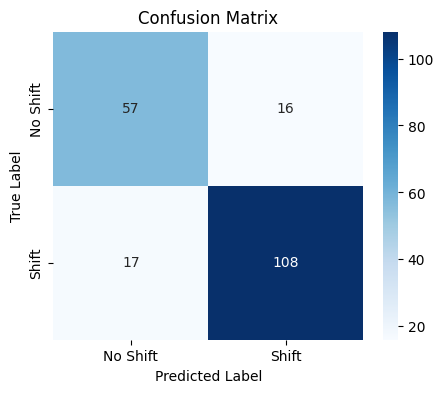

In [12]:
accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred)
recall = recall_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred)

print("\n=== Evaluation Results (ConvNeXt-Small) ===")
print(f"Accuracy : {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall   : {recall:.4f}")
print(f"F1 Score : {f1:.4f}")
print("\nClassification Report:\n")
print(classification_report(y_true, y_pred, target_names=["No Shift", "Shift"]))

cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=["No Shift", "Shift"],
            yticklabels=["No Shift", "Shift"])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

In [13]:
torch.save(model.state_dict(), "midlineshift_presence_convnext_small.pth")